<a href="https://colab.research.google.com/github/poitrew11/Young-Yandex-homeworks/blob/main/HW%204.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

# __________start of block__________

def args_and_kwargs(*args, **kwargs):
    return args, kwargs

def parse_pytorch_model(model_str):
    def parse_layer(layer_str):
        layer_name, params = layer_str.split("(", 1)
        layer_info = {"type": layer_name.strip()}
        params_template = layer_str.replace(layer_name, "args_and_kwargs")

        param_dict = {}
        if len(params):
            args, kwargs = eval(params_template)
            if len(args) or len(kwargs):
                param_dict["args"] = args
                for name, value in kwargs.items():
                    param_dict[name] = value
        layer_info["parameters"] = param_dict
        return layer_info

    model_dict = {}
    lines = model_str.splitlines()
    model_name = lines[0].strip("()")
    model_dict["model_name"] = model_name
    model_dict["layers"] = []

    layer_regex = re.compile(r"\((\d+)\): (.+)")
    for line in lines[1:]:
        line = line.strip()
        match = layer_regex.match(line)
        if match:
            index, layer = match.groups()
            model_dict["layers"].append({"index": int(index), "layer": parse_layer(layer)})
    return model_dict

# __________end of block__________

In [ ]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


In [ ]:
!wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"


--2025-04-21 07:53:55--  https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict [following]
--2025-04-21 07:53:56--  https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272446 (6.0M) [application/octet-stream]
Saving to: ‘hw_overfitting_data_dict.npy’

hw_overfitting_data 100%[===================>]   5.98M  --.-KB/s 

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 298kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.55MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.83MB/s]


Text(0.5, 1.0, 'Image label: 0')

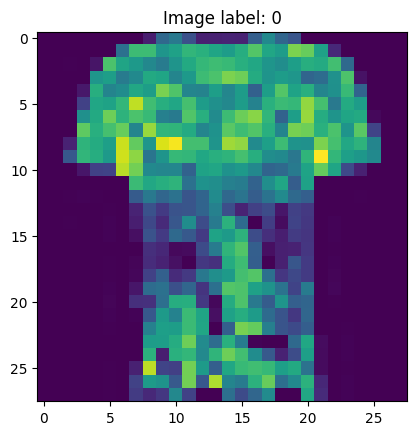

In [ ]:
device = torch.device('cpu')
train_fmnist_data = FashionMNIST('.', transform = torchvision.transforms.ToTensor(), train = True, download = True)
test_fmnist_data = FashionMNIST('.', train = False, transform = torchvision.transforms.ToTensor(), download = True)

train_data_loader = torch.utils.data.DataLoader(train_fmnist_data, batch_size = 32, shuffle = True)
test_data_loader = torch.utils.data.DataLoader(test_fmnist_data, shuffle = False, batch_size = 32)

random_batch = next(iter(train_data_loader))

_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")

In [ ]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(32 * 7 * 7, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.view(-1, 32 * 7 * 7)
    x = self.fc1(x)
    return x

model_task_1 = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_task_1.parameters(), lr = 0.003)

def train_model(model, train_loader, test_loader, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, '
              f'Test Accuracy: {accuracy:.2f}%')
train_model(model_task_1, train_data_loader, test_data_loader)


Epoch 1, Loss: 0.4126, Test Accuracy: 87.87%
Epoch 2, Loss: 0.2856, Test Accuracy: 89.27%
Epoch 3, Loss: 0.2538, Test Accuracy: 89.94%
Epoch 4, Loss: 0.2348, Test Accuracy: 90.13%
Epoch 5, Loss: 0.2216, Test Accuracy: 90.48%


In [ ]:
model_task_1.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block_________

Everything seems fine!


In [ ]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on train set: 0.93247
Neural network accuracy on test set: 0.9059


In [ ]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Test accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
    "model_task_1": parse_pytorch_model(str(model_task_1)),
}

with open("submission_dict_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_task_1.json`")
# __________end of block__________

File saved to `submission_dict_task_1.json`


In [ ]:
class SimpleCNNN(nn.Module):
    def __init__(self):
        super(SimpleCNNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(2048, 4096, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4096 * 3 * 3, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = F.relu(self.conv7(x))
        x = x.view(-1, 4096 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model_task_2 = SimpleCNNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_task_1.parameters(), lr = 0.001)

In [ ]:
def training_model(model, train_loader, test_loader, epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, '
              f'Test Accuracy: {accuracy:.2f}%')
model_task_2 = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_task_2.parameters(), lr = 0.001)
#training_model(model_task_2, train_data_loader, test_data_loader)

In [ ]:
layers_task_2 = []
for element in parse_pytorch_model(str(model_task_2)).get("layers", []):
    layer_name = element["layer"]["type"]
    assert "dropout" not in layer_name.lower(), "Do not use Dropout in Task 2!"
    assert "batchnorm" not in layer_name.lower(), "Do not use BatchNorm in Task 2!"
    layers_task_2.append(layer_name)

In [ ]:
model_task_2.to(device)
train_acc_task_2 = get_accuracy(model_task_2, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_2:3.5}")
test_acc_task_2 = get_accuracy(model_task_2, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_2:3.5}")

Neural network accuracy on train set: 0.98833
Neural network accuracy on test set: 0.9005


In [ ]:
assert train_acc_task_2 >= test_acc_task_2, "Train accuracy must be higher than task accuracy"
assert train_acc_task_2 >= 0.88, "Train accuracy must be higher than 0.88"
assert (
    train_acc_task_2 - test_acc_task_2 >= 0.04
), "Test accuracy should be at least 0.04 lower that train."

In [ ]:
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_2": parse_pytorch_model(str(model_task_2)),
    }
)

with open("submission_dict_tasks_1_and_2.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_tasks_1_and_2.json`")

File saved to `submission_dict_tasks_1_and_2.json`


In [ ]:
model_task_3 = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_task_3.parameters(), lr = 0.002)
training_model(model_task_3, train_data_loader, test_data_loader, epochs = 2)

Epoch 1, Loss: 0.4184, Test Accuracy: 87.47%
Epoch 2, Loss: 0.2870, Test Accuracy: 89.23%


In [ ]:
assert (
    layers_task_2 is not None
), "Initializa layers_task_2 vairable which contains list of layers in task 2 model"

In [ ]:
layers_task_3 = []
for element in parse_pytorch_model(str(model_task_3)).get("layers", []):
    layer_name = element["layer"]["type"]
    layers_task_3.append(layer_name)


idx = 0
for model_3_layer in layers_task_3:
    model_2_layer = layers_task_2[idx]
    if "dropout" not in model_3_layer.lower() and "batchnorm" not in model_3_layer.lower():
        assert (
            model_3_layer == model_2_layer
        ), "Models in tasks 2 and 3 must share the architecture except for Dropout and BatchNorm!"
        idx += 1

In [ ]:
model_task_3.to(device)
train_acc_task_3 = get_accuracy(model_task_3, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_3:3.5}")
test_acc_task_3 = get_accuracy(model_task_3, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_3:3.5}")

Neural network accuracy on train set: 0.9069
Neural network accuracy on test set: 0.8923


In [ ]:
assert train_acc_task_3 >= 0.88, "Train accuracy must be higher than 0.88"
assert train_acc_task_3 >= 0.865, "Test accuracy must be higher than 0.865"
assert (
    train_acc_task_3 - test_acc_task_3 <= 0.015
), "Test accuracy should not be lower that train more than by 0.015"

In [ ]:
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_3": parse_pytorch_model(str(model_task_3)),
    }
)

with open("submission_dict_final.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_final.json`")

File saved to `submission_dict_final.json`


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving submission_dict_tasks_1_and_2.json to submission_dict_tasks_1_and_2.json


In [ ]:
import json

with open("submission_dict_tasks_1_and_2.json", "r") as f:
    submission_dict = json.load(f)
